<div>
    <img src="https://storage.googleapis.com/kaggle-datasets-images/986308/1665609/1f835a26900f388d8f39e33691e46570/dataset-cover.jpg"/>
</div>

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow import nn
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [25]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the period
ticker = "AAPL"
period = "5y"

# Download the historical data
data = yf.download(ticker, period=period)

# Select the required columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']]

# Display the first few rows
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close     Volume  Adj Close
Date                                                                        
2019-07-24  51.917500  52.287498  51.792500  52.167500   59966400  50.346710
2019-07-25  52.222500  52.310001  51.682499  51.755001   55638400  49.948612
2019-07-26  51.869999  52.432499  51.785000  51.935001   70475600  50.122326
2019-07-29  52.115002  52.660000  52.110001  52.419998   86693600  50.590389
2019-07-30  52.189999  52.540001  51.827499  52.195000  135742800  50.373253


In [26]:
data = data.reset_index()

In [27]:
data

,Date,Open,High,Low,Close,Volume,Adj Close
0,2019-07-24,51.917500,52.287498,51.792500,52.167500,59966400,50.346710
1,2019-07-25,52.222500,52.310001,51.682499,51.755001,55638400,49.948612
2,2019-07-26,51.869999,52.432499,51.785000,51.935001,70475600,50.122326
3,2019-07-29,52.115002,52.660000,52.110001,52.419998,86693600,50.590389
4,2019-07-30,52.189999,52.540001,51.827499,52.195000,135742800,50.373253
...,...,...,...,...,...,...,...
1253,2024-07-17,229.449997,231.460007,226.639999,228.880005,57345900,228.880005
1254,2024-07-18,230.279999,230.440002,222.270004,224.179993,66034600,224.179993
1255,2024-07-19,224.820007,226.800003,223.279999,224.309998,49151500,224.309998
1256,2024-07-22,227.009995,227.779999,223.089996,223.960007,48201800,223.960007


<h1 id="dataset" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [28]:
#df = pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')
data = data.set_index('Date').sort_index()
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2019-07-24,51.917500,52.287498,51.792500,52.167500,59966400,50.346710
2019-07-25,52.222500,52.310001,51.682499,51.755001,55638400,49.948612
2019-07-26,51.869999,52.432499,51.785000,51.935001,70475600,50.122326
2019-07-29,52.115002,52.660000,52.110001,52.419998,86693600,50.590389
2019-07-30,52.189999,52.540001,51.827499,52.195000,135742800,50.373253


<h1 id="parameters" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Parameters
        <a class="anchor-link" href="#parameters" target="_self">¶</a>
    </center>
</h1>

In [29]:
seq_len = 24
n_seq = 6
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

<h1 id="preprocess" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Preprocess
        <a class="anchor-link" href="#preprocess" target="_self">¶</a>
    </center>
</h1>

In [30]:
def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])

    return data

In [31]:
df = data

In [32]:
stock_data = preprocess(df.values, seq_len)

In [53]:
seq_len

24

<h1 id="modules" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Modules
        <a class="anchor-link" href="#modules" target="_self">¶</a>
    </center>
</h1>

In [33]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'LSTM_{i + 1}'))

    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='OUT'))
    return model

In [34]:
class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model

In [35]:
class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model

In [36]:
class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery

In [37]:
class Embedder(Model):

    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder

In [38]:
class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model

<h1 id="definitions" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Definitions
        <a class="anchor-link" href="#definitions" target="_self">¶</a>
    </center>
</h1>

In [39]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        # AutoEncoder
        H = self.embedder(X)
        X_tilde = self.recovery(H)

        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        # Adversarial Supervise Architecture
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')


        # Adversarial architecture in latent space
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')

        #Synthetic data generation
        X_hat = self.recovery(H_hat)

        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')


        # Final discriminator model
        Y_real = self.discriminator(H)

        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        # Loss functions
        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()

<h1 id="trainingModules" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Training Modules
        <a class="anchor-link" href="#trainingModules" target="_self">¶</a>
    </center>
</h1>

In [40]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)

    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))

In [41]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)

<h1 id="training" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [42]:
autoencoder_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Emddeding network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

Emddeding network training: 100%|██████████| 5000/5000 [12:35<00:00,  6.62it/s]


In [43]:
supervisor_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

Supervised network training: 100%|██████████| 5000/5000 [09:37<00:00,  8.66it/s]


In [44]:
generator_opt = Adam(learning_rate=learning_rate)
embedder_opt = Adam(learning_rate=learning_rate)
discriminator_opt = Adam(learning_rate=learning_rate)

In [45]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for _ in tqdm(range(train_steps), desc='Joint networks training'):

    #Train the generator (k times as often as the discriminator)
    # Here k=2
    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
        Z_ = next(synth.get_batch_noise())

        # Train the generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)

    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

Joint networks training: 100%|██████████| 5000/5000 [3:34:33<00:00,  2.57s/it]


<h1 id="analyzing" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Analyzing
        <a class="anchor-link" href="#analyzing" target="_self">¶</a>
    </center>
</h1>

In [46]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Synthetic data generation: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


In [47]:
data_reduced

array([[0.41944888, 0.42384312, 0.41762152, ..., 0.42648366, 0.34175447,
        0.41896874],
       [0.4226262 , 0.43212223, 0.4193199 , ..., 0.40674436, 0.17455131,
        0.39946884],
       [0.40397322, 0.40629435, 0.40239191, ..., 0.41038248, 0.33185592,
        0.40313837],
       ...,
       [0.52896035, 0.5330093 , 0.538187  , ..., 0.51894253, 0.1884465 ,
        0.51029659],
       [0.49421062, 0.50365585, 0.50028387, ..., 0.4913264 , 0.13617271,
        0.48338799],
       [0.46766869, 0.46780317, 0.47373541, ..., 0.46354933, 0.09457546,
        0.45632248]])

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

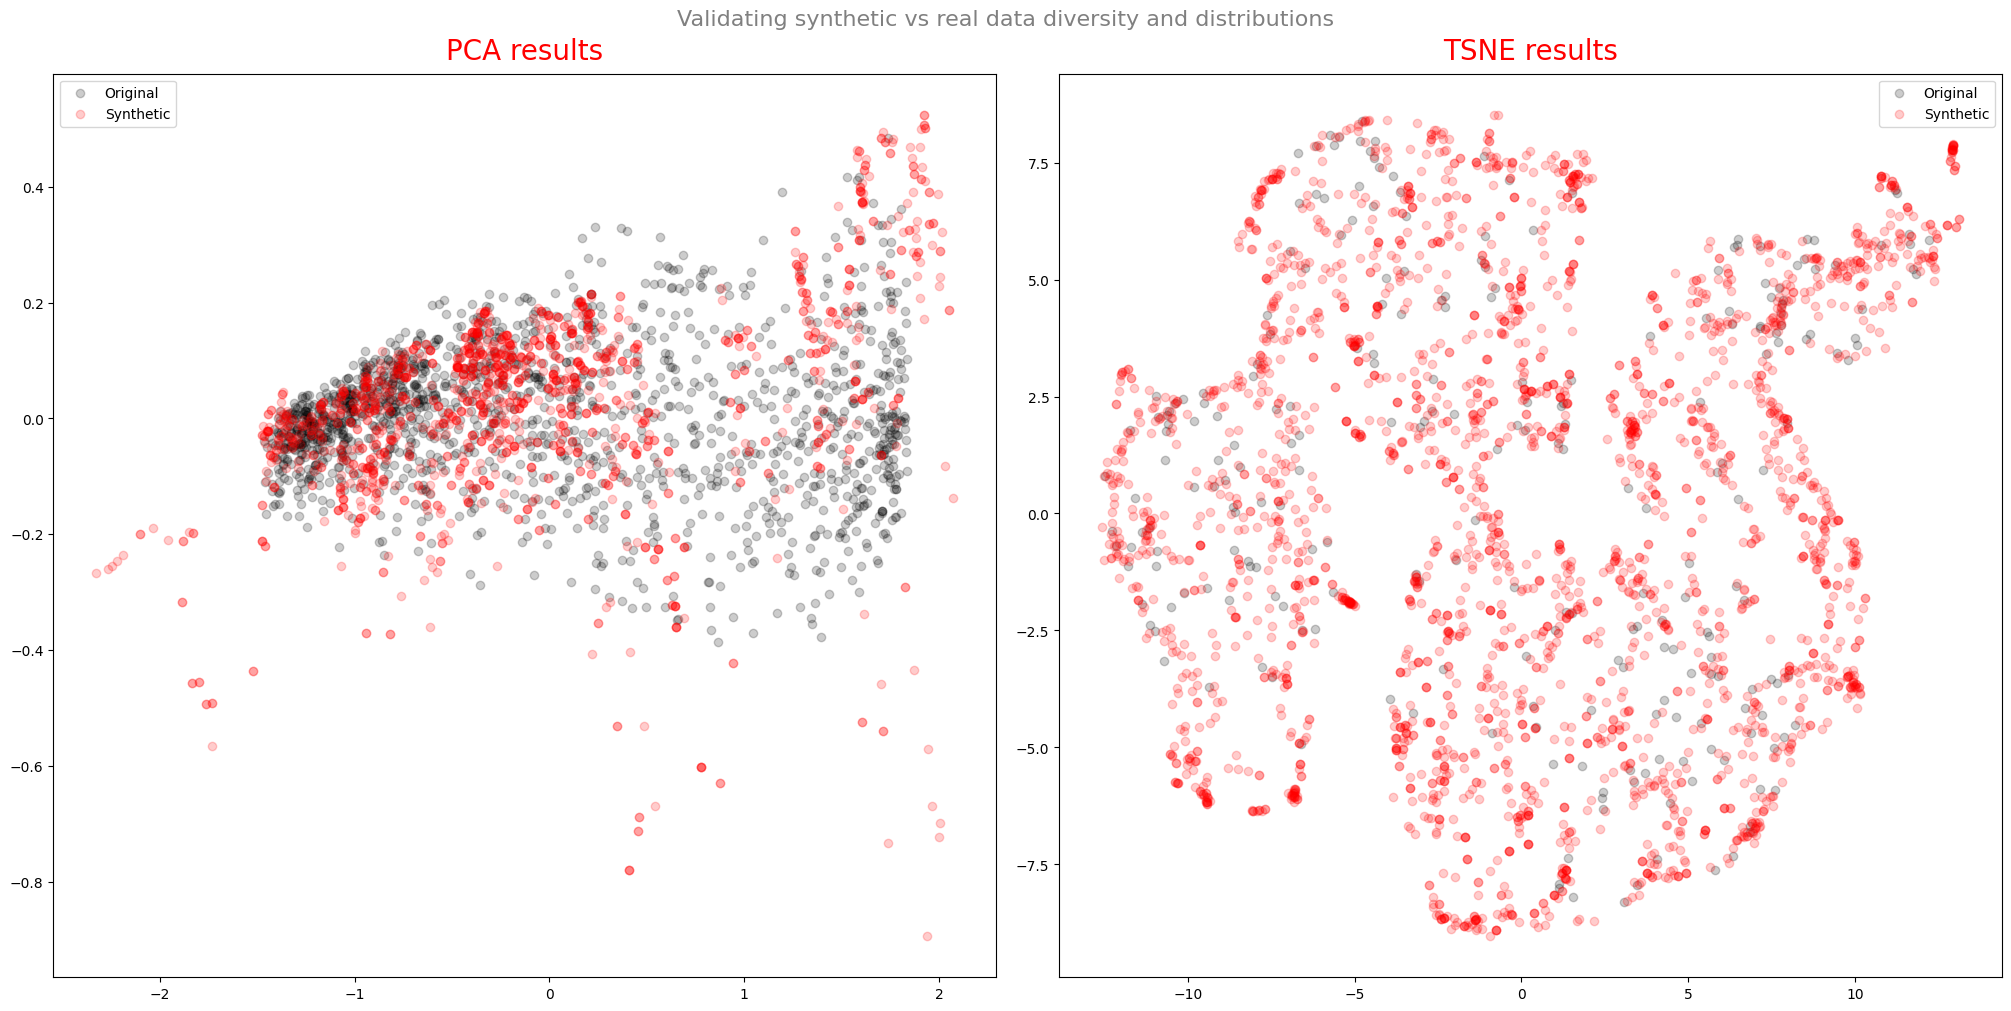

In [48]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

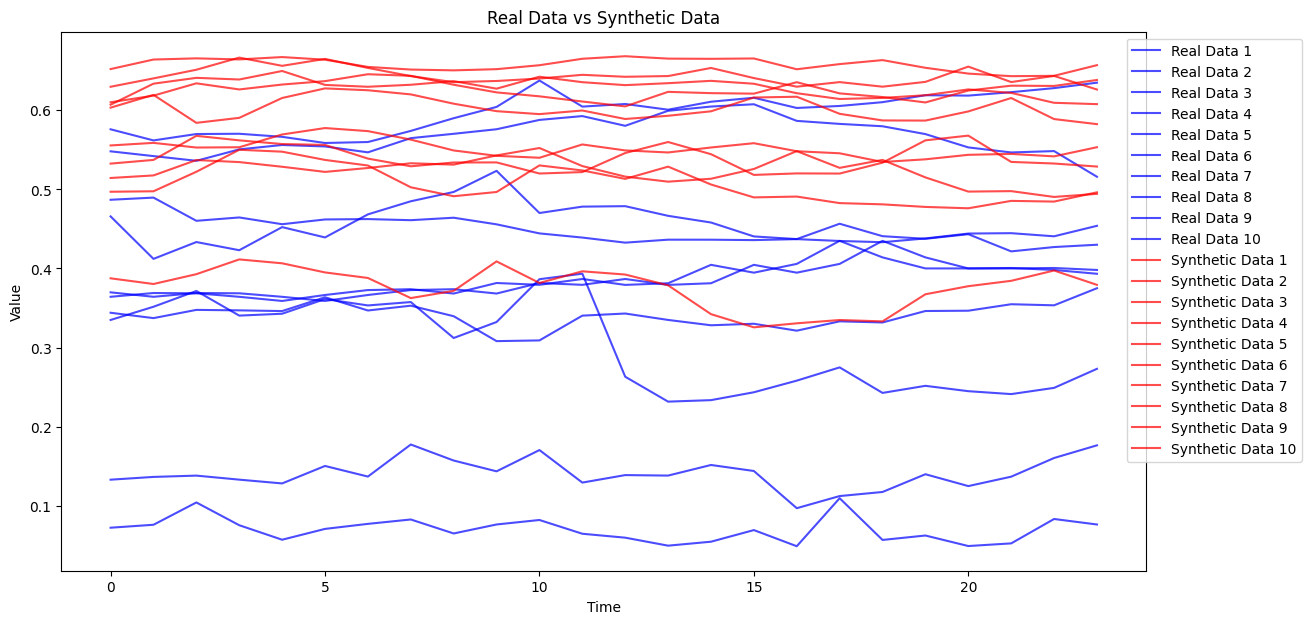

In [50]:
# Flatten the data by taking the mean across one axis for plotting
real_sample_flattened = real_sample.mean(axis=2)  # Shape (sample_size, 24)
synthetic_sample_flattened = synthetic_sample.mean(axis=2)  # Shape (sample_size, 24)

# Plot line plots of real data vs synthetic data on time axis
time_axis = np.arange(real_sample_flattened.shape[1])

plt.figure(figsize=(14, 7))

# Plot real data (mean across samples)
for i in range(min(sample_size, 10)):  # Plot first 10 samples for clarity
    plt.plot(time_axis, real_sample_flattened[i], label=f'Real Data {i+1}', color='blue', alpha=0.7)

# Plot synthetic data (mean across samples)
for i in range(min(sample_size, 10)):  # Plot first 10 samples for clarity
    plt.plot(time_axis, synthetic_sample_flattened[i], label=f'Synthetic Data {i+1}', color='red', alpha=0.7)

plt.title('Real Data vs Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

In [51]:
stock_data

[array([[0.62004506, 0.6341746 , 0.63286385, 0.64388556, 0.10151028,
         0.64112067],
        [0.60869275, 0.61670108, 0.61994109, 0.61895053, 0.05329824,
         0.61657364],
        [0.62004506, 0.62218818, 0.62496957, 0.61900421, 0.06128732,
         0.61662643],
        [0.6190324 , 0.61840585, 0.62583472, 0.62736948, 0.04447951,
         0.62486164],
        [0.61929891, 0.622934  , 0.62907896, 0.62570716, 0.08519817,
         0.62322517],
        [0.62484177, 0.63049875, 0.63486442, 0.63444775, 0.07058585,
         0.63182975],
        [0.62329619, 0.63204371, 0.63475625, 0.63970293, 0.05881777,
         0.6370031 ],
        [0.62489512, 0.62804824, 0.63535103, 0.63348257, 0.06429109,
         0.63087962],
        [0.61951206, 0.61728708, 0.62659169, 0.62683321, 0.04340264,
         0.62433367],
        [0.6168472 , 0.62224151, 0.62545627, 0.62672602, 0.06295804,
         0.62422809],
        [0.60107131, 0.61947129, 0.61247939, 0.6286028 , 0.11031435,
         0.62607571],

<h1 id="credits" style="color:#34a68a; background:#5c594f; border:0.5px dotted #34a68a;">
    <center>Credits
        <a class="anchor-link" href="#credits" target="_self">¶</a>
    </center>
</h1>

Full credits goes to [Fabiana Clemented](https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239) for this implementation.<br>
Paper on [TimeGAN](https://papers.nips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf)